#TODO:
- tinker with logarithmic values
- feature engineering
- use hyperopt
- XGBoost learning curves (lesson 3.2) X
- General refactor
- Feature importances + eli5
- Other methods?
- Browse kaggle notebooks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from scikitplot.estimators import plot_learning_curve
np.random.seed(2020)

import seaborn as sns

from scipy.stats import pearsonr

%matplotlib inline

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.sample(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
236,88299702,M,23.21,26.97,153.50,1670.0,0.09509,0.1682,0.19500,0.12370,...,34.51,206.00,2944.0,0.14810,0.4126,0.5820,0.25930,0.3103,0.08677,NaN
106,863031,B,11.64,18.33,75.17,412.5,0.11420,0.1017,0.07070,0.03485,...,29.26,85.51,521.7,0.16880,0.2660,0.2873,0.12180,0.2806,0.09097,NaN
284,8912284,B,12.89,15.70,84.08,516.6,0.07818,0.0958,0.11150,0.03390,...,19.69,92.12,595.6,0.09926,0.2317,0.3344,0.10170,0.1999,0.07127,NaN
262,888570,M,17.29,22.13,114.40,947.8,0.08999,0.1273,0.09697,0.07507,...,27.24,137.90,1295.0,0.11340,0.2867,0.2298,0.15280,0.3067,0.07484,NaN
356,9010259,B,13.05,18.59,85.09,512.0,0.10820,0.1304,0.09603,0.05603,...,24.85,94.22,591.2,0.13430,0.2658,0.2573,0.12580,0.3113,0.08317,NaN
544,922297,B,13.87,20.70,89.77,584.8,0.09578,0.1018,0.03688,0.02369,...,24.75,99.17,688.6,0.12640,0.2037,0.1377,0.06845,0.2249,0.08492,NaN
280,8912049,M,19.16,26.60,126.20,1138.0,0.10200,0.1453,0.19210,0.09664,...,35.90,159.80,1724.0,0.17820,0.3841,0.5754,0.18720,0.3258,0.09720,NaN
430,907914,M,14.90,22.53,102.10,685.0,0.09947,0.2225,0.27330,0.09711,...,27.57,125.40,832.7,0.14190,0.7090,0.9019,0.24750,0.2866,0.11550,NaN
121,86517,M,18.66,17.12,121.40,1077.0,0.10540,0.1100,0.14570,0.08665,...,24.90,145.40,1549.0,0.15030,0.2291,0.3272,0.16740,0.2894,0.08456,NaN
487,913505,M,19.44,18.82,128.10,1167.0,0.10890,0.1448,0.22560,0.11940,...,30.39,153.90,1740.0,0.15140,0.3725,0.5936,0.20600,0.3266,0.09009,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

<BarContainer object of 2 artists>

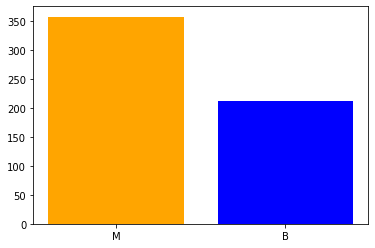

In [5]:
plt.bar(x=data.diagnosis.unique(), height=data.diagnosis.value_counts(), color=['orange', 'blue'])

In [6]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


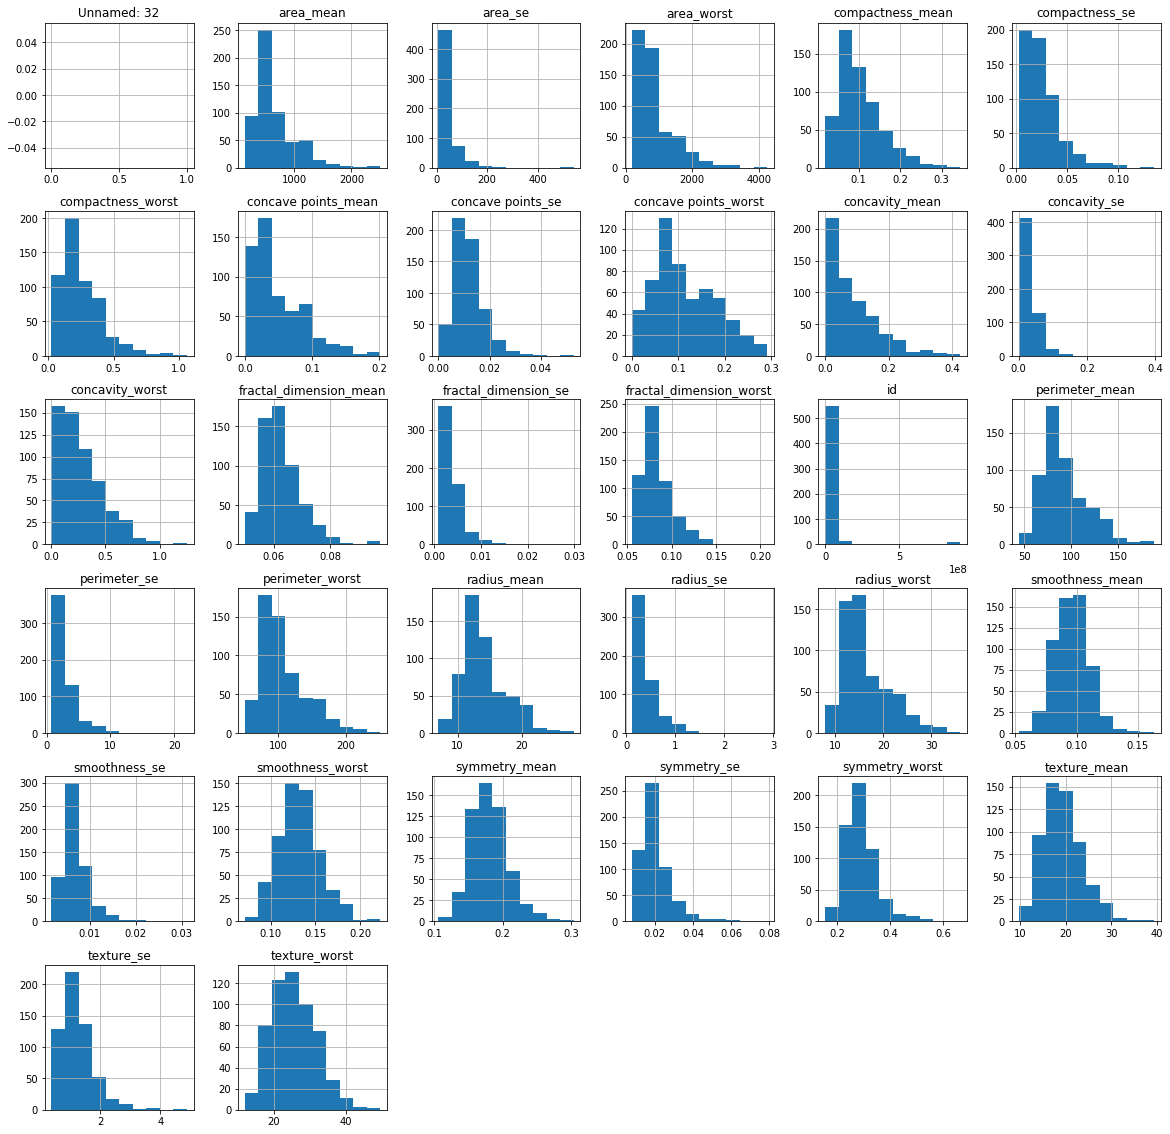

In [7]:
data.hist(figsize=(20, 20));

In [8]:
X = data.drop(['id', 'Unnamed: 32'], axis=1)
y = X.pop('diagnosis')

The code below is standardizing and preparing the data in order to be able to compare values on a violin plot.

In [9]:
standardized = (X - X.mean()) / X.std()
plt_data = pd.concat([y, standardized], axis=1)
plt_data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,...,1.885031,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312
1,M,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,...,1.804340,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943
2,M,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,...,1.510541,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214
3,M,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,...,-0.281217,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672
4,M,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,...,1.297434,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,2.109139,0.720838,2.058974,2.341795,1.040926,0.218868,1.945573,2.318924,-0.312314,...,1.899514,0.117596,1.751022,2.013529,0.378033,-0.273077,0.663928,1.627719,-1.358963,-0.708467
565,M,1.703356,2.083301,1.614511,1.722326,0.102368,-0.017817,0.692434,1.262558,-0.217473,...,1.535369,2.045599,1.420690,1.493644,-0.690623,-0.394473,0.236365,0.733182,-0.531387,-0.973122
566,M,0.701667,2.043775,0.672084,0.577445,-0.839745,-0.038646,0.046547,0.105684,-0.808406,...,0.560868,1.373645,0.578492,0.427529,-0.808876,0.350427,0.326479,0.413705,-1.103578,-0.318129
567,M,1.836725,2.334403,1.980781,1.733693,1.524426,3.269267,3.294046,2.656528,2.135315,...,1.959515,2.235958,2.301575,1.651717,1.429169,3.901415,3.194794,2.287972,1.917396,2.217684


In [10]:
plt_data = pd.melt(plt_data, id_vars='diagnosis', var_name='features')
plt_data

,diagnosis,features,value
0,M,radius_mean,1.096100
1,M,radius_mean,1.828212
2,M,radius_mean,1.578499
3,M,radius_mean,-0.768233
4,M,radius_mean,1.748758
...,...,...,...
17065,M,fractal_dimension_worst,-0.708467
17066,M,fractal_dimension_worst,-0.973122
17067,M,fractal_dimension_worst,-0.318129
17068,M,fractal_dimension_worst,2.217684


That's a lot of data to look through. Let's split it into 3 groups: mean, se and worst. Each group has 10 features, so I'll just iterate through those. Let's also add a swarmplot to each group.

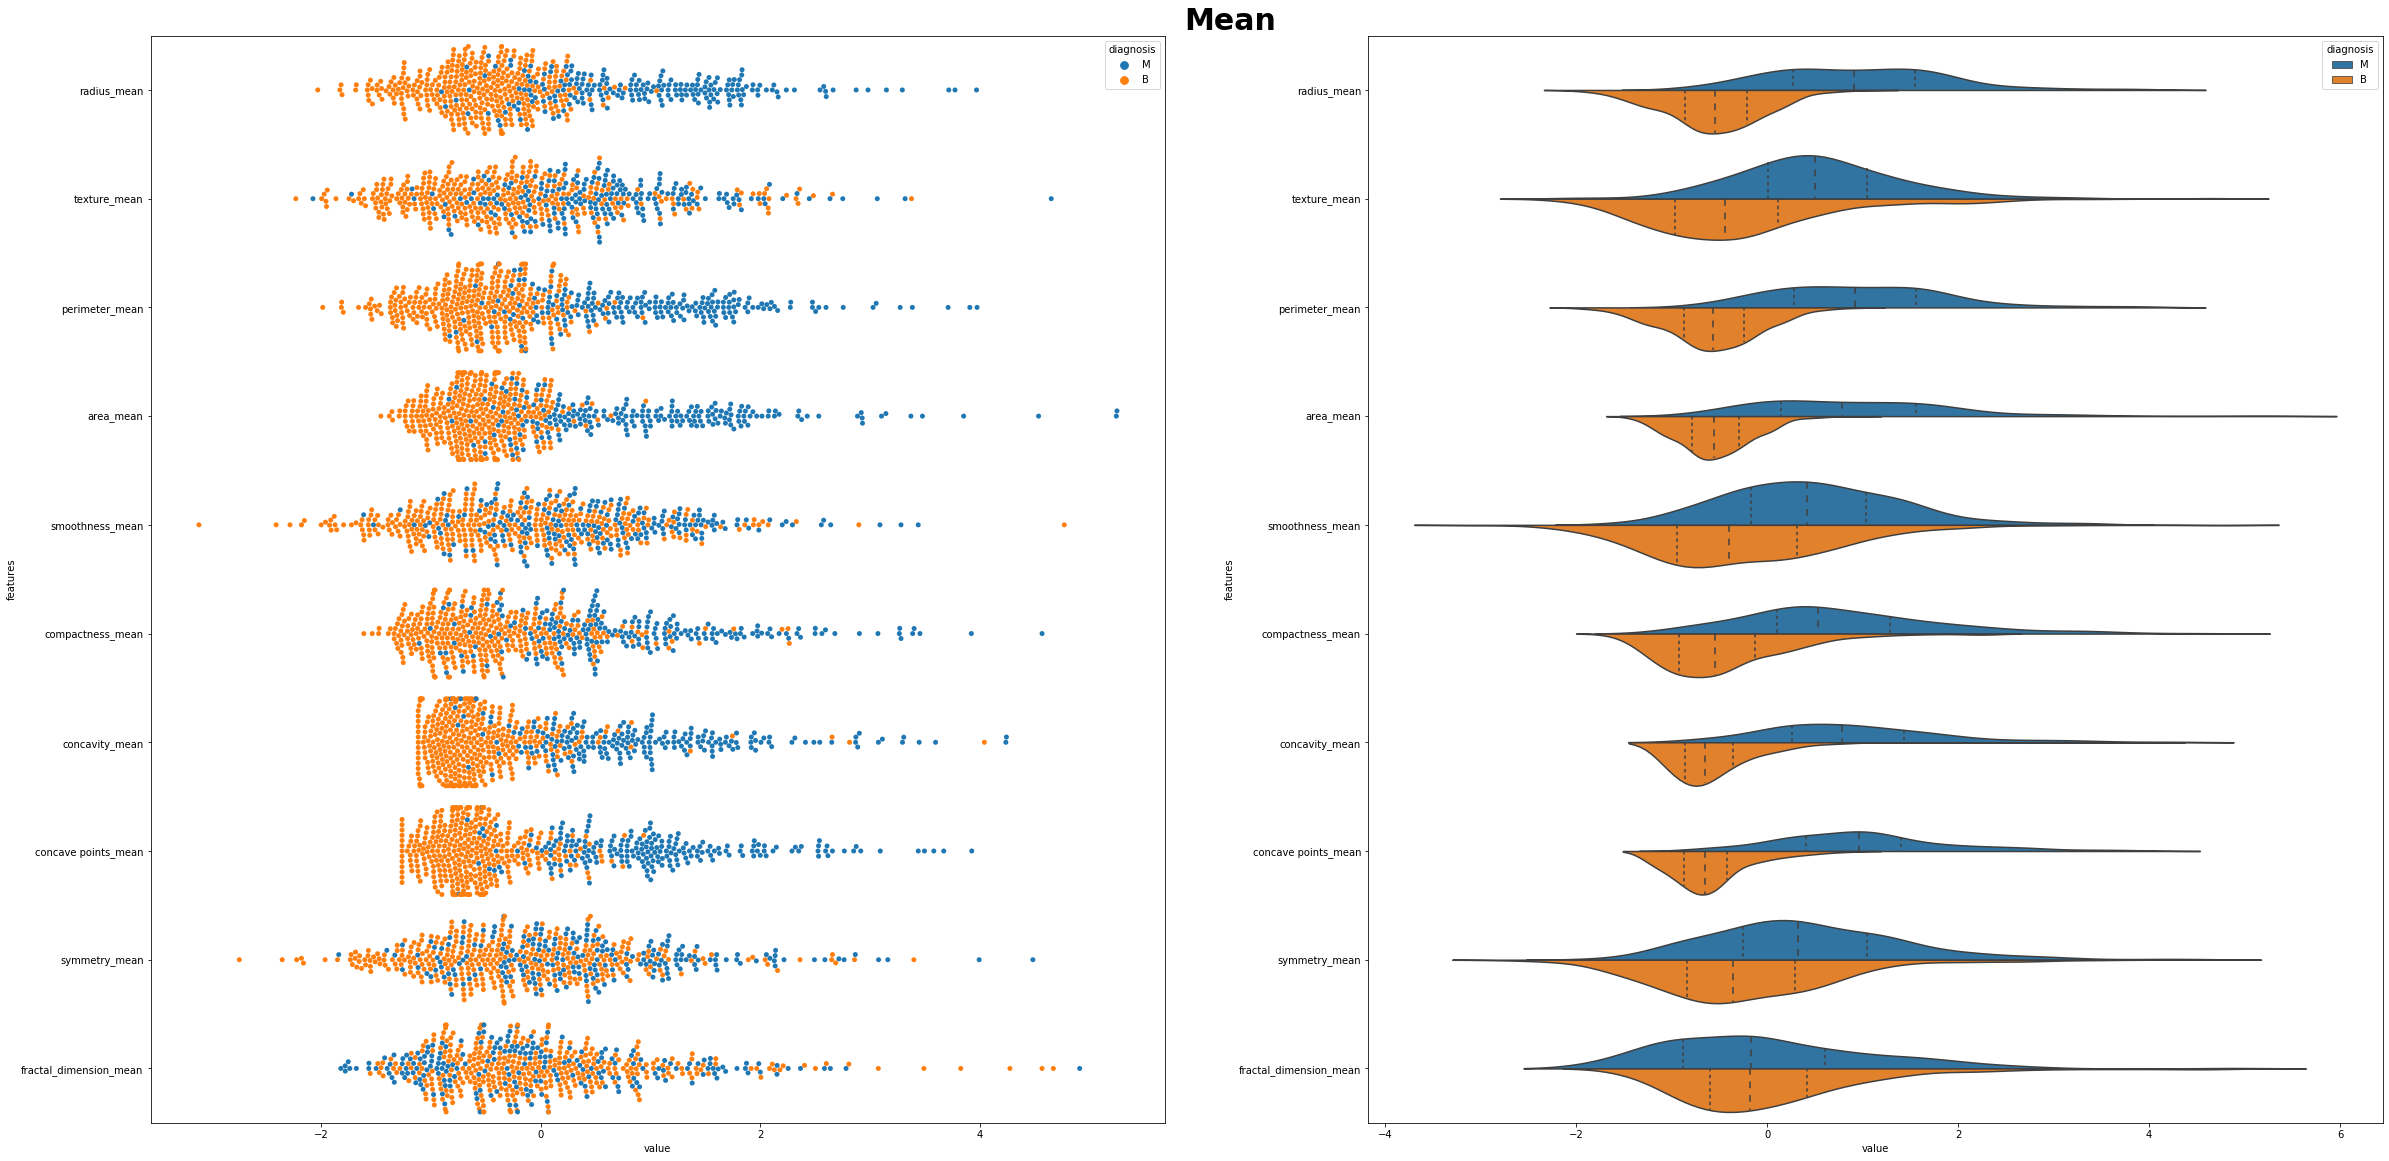

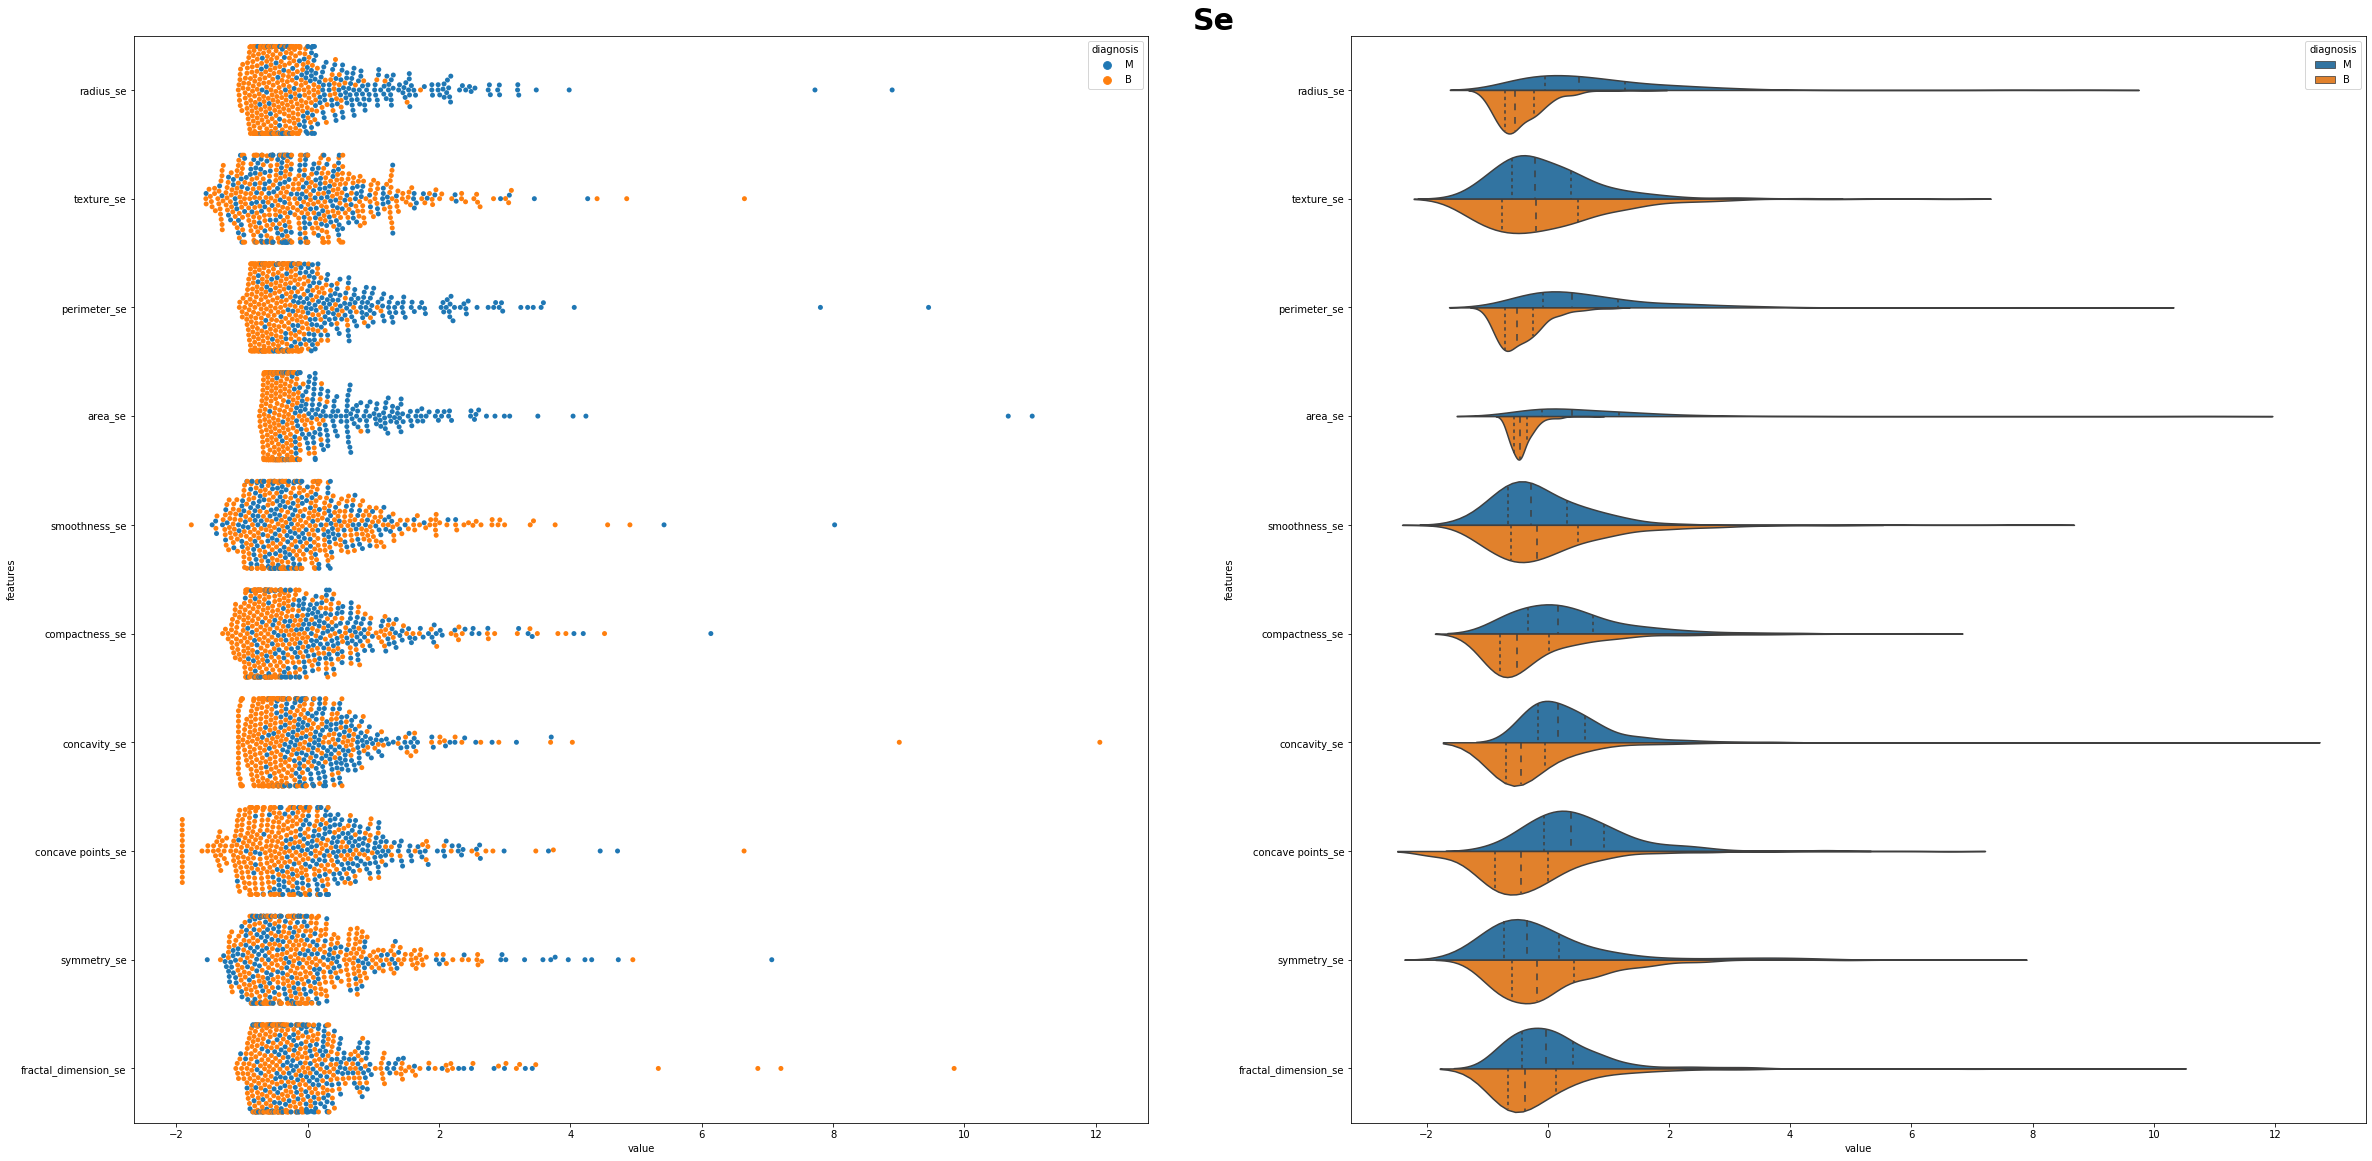

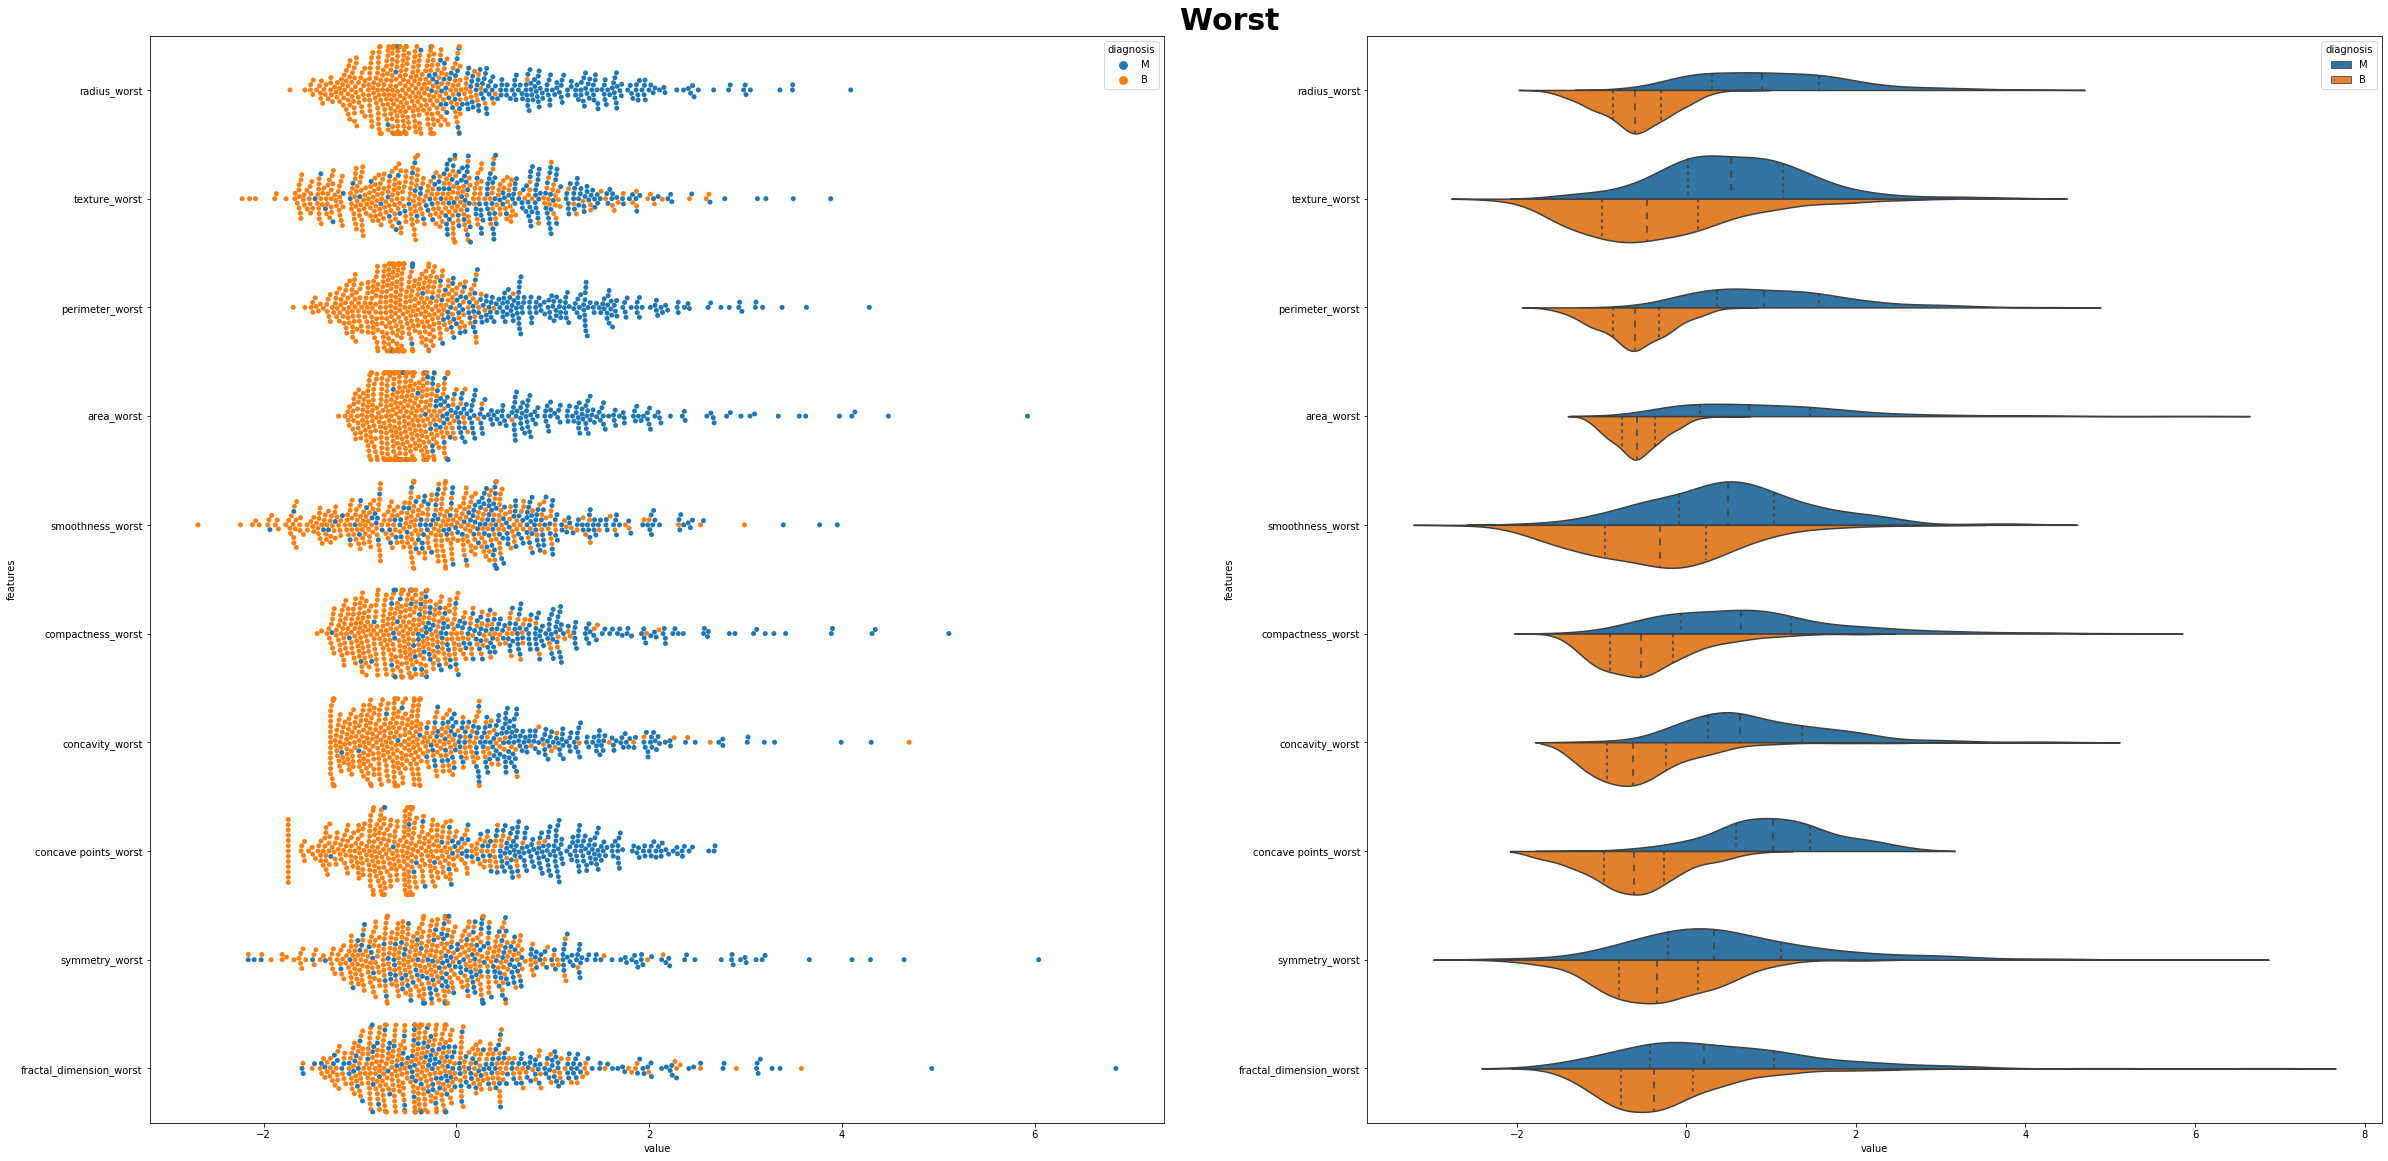

In [11]:
for i in range(0, 21, 10):
    plt_data = pd.concat([y, standardized.iloc[:, i:i+10]], axis=1)
    plt_data = pd.melt(plt_data, id_vars='diagnosis', var_name='features')
    plt.figure(figsize=(40, 20));
    plt.suptitle(plt_data.features[0].split('_')[1].title(), size=30, y=.9 , weight='bold')
    plt.subplot('120')
    sns.violinplot(x='value', y='features', hue='diagnosis', data=plt_data, split=True, inner='quart');
    plt.subplot('121')
    sns.swarmplot(x='value', y='features', hue='diagnosis', data=plt_data);

Looking at those plots we can already see, that some features appear to be more promising than others. For example `concave points_worst`'s median values for benign and malignant tumors are far away from each other, which may make calssification a lot easier. Also, distribution of `area_se` is very different for M and B diagnosis.

Swarmplots can help us to choose features that best separate malignant and benign tumors

Second thing that comes to mind is that a lot of the features are correlated with each other, which mean than we can narrow down the feature set that we will make our predictions with.

/home/marcin/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


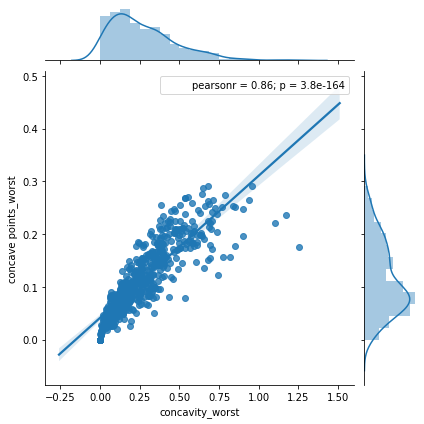

In [12]:
plot = sns.jointplot(X.loc[:, 'concavity_worst'], X.loc[:, 'concave points_worst'], kind='reg');
plot.annotate(pearsonr);

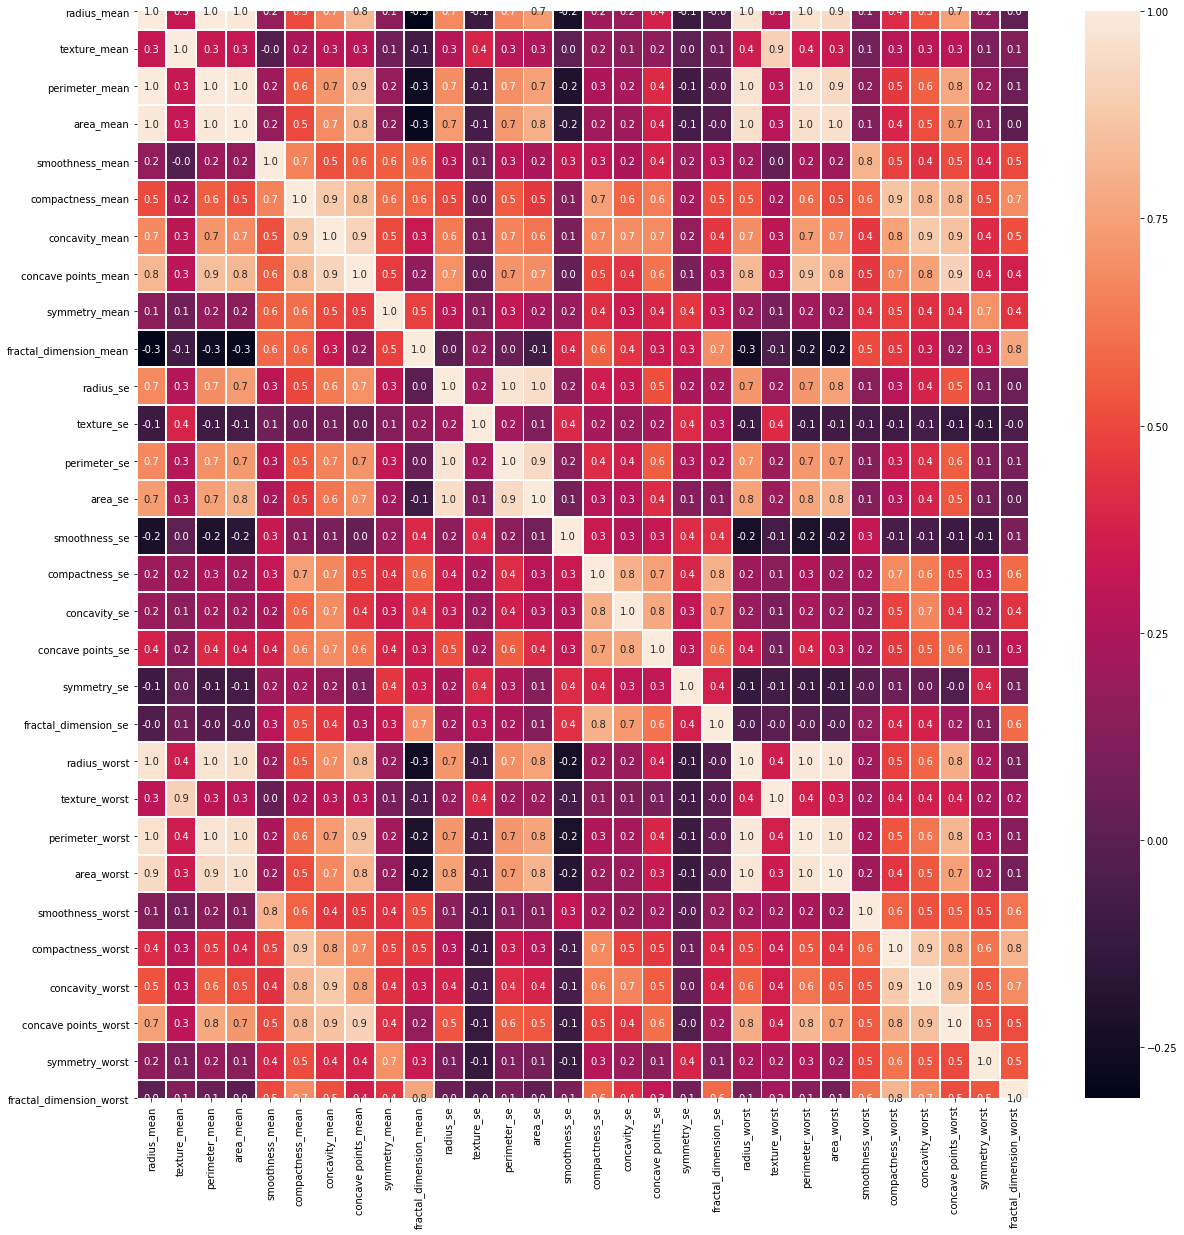

In [13]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(X.corr(), annot=True, ax=ax, linewidths=.9, fmt='.1f')

In [14]:
correlations = X.corr().unstack().sort_values(ascending=False).sort_index(level=[0, 1]).to_frame()

In [15]:
correlations = correlations.sort_values(by=0, ascending=False).to_dict()

In [16]:
indices_to_del = []
for key in correlations[0].keys():
    same_key = (key[0], key[0])
    paired_key = (key[1], key[0])
    if (paired_key not in indices_to_del) and (key not in indices_to_del):
        indices_to_del.append(paired_key)
        
    if same_key not in indices_to_del:
        indices_to_del.append(same_key)

In [17]:
correlations = pd.DataFrame.from_dict(correlations).drop(indices_to_del)

In [18]:
correlations

0
area_mean     area_worst         0.959213
              compactness_mean   0.498502
              compactness_se     0.212583
              concave points_se  0.372320
              perimeter_mean     0.986507
...                                   ...
texture_worst smoothness_se     -0.074743
              smoothness_worst   0.225429
              symmetry_se       -0.077473
              symmetry_worst     0.233027
              texture_se         0.409003

[435 rows x 1 columns]

In [ ]:
for pair in correlations[correlations[0] > 0.9].index:
    plot = sns.jointplot(X.loc[:, pair[0]], X.loc[:, pair[1]], kind='reg');
    plot.annotate(pearsonr);

Looking at those plots we can see that we have a lot of features that are strongly correlated to each other.

Let's try to take one feat from each group and put it through some models.

In [ ]:
feats = ['area_worst', 'area_se', 'concave points_mean']

In [ ]:
data[feats].hist(bins=100);

We can clearly see that those feats are strongly skewed. We could try to normalize them using logarrithmic transformation.

In [ ]:
shift = 0.02
log_feats = np.log(data[feats] + shift)
log_feats.hist(bins=100);

In [ ]:
new_feats = []
for feat in feats:
    name = 'log_{}'.format(feat)
    data[name] = np.log(data[feat] + shift)
    new_feats.append(name)

Let's prepare some helper functions

In [ ]:
def get_models():
    return [
        DecisionTreeClassifier(min_samples_leaf=5, random_state=2020),
        RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=2020),
        XGBClassifier(random_state=2020)
    ]

In [ ]:
def prepare_data(data, chosen_feats):
    X = data[chosen_feats]
    feats_to_del = ['id', 'Unnamed: 32', 'diagnosis']
    for feat_to_del in feats_to_del:
        if feat_to_del in X.columns: del X[feat_to_del]

    columns = X.columns
    return (X.values, np.array([1 if el=='M' else 0 for el in data['diagnosis']]), columns)

In [ ]:
def run(models, X, y, plt=True):
    cv = KFold(n_splits=5, shuffle=True, random_state=2020)
    results = []

    for model in models:
        name = type(model).__name__
        scores = []
        for train_ids, test_ids in cv.split(X, y):
            model.fit(X[train_ids], y[train_ids])
            y_pred = model.predict(X[test_ids])
            score = accuracy_score(y[test_ids], y_pred)
            scores.append(score)


        if plt:
            fig = plt.figure(figsize=(30, 10))
            fig.suptitle(name)
            sp1 = fig.add_subplot(121)
            plot_learning_curve(model, X, y, cv=cv, shuffle=True, ax=sp1)
            sp2 = fig.add_subplot(122)
            pd.Series(model.feature_importances_, index=columns).nlargest(10).plot(kind='bar', title='Feature importances')
            
        print(name, np.mean(scores), np.std(scores))

In [ ]:
models = get_models()

In [ ]:
X, y, columns = prepare_data(data, feats)

In [ ]:
run(models, X, y, plt=False)

In [ ]:
models = get_models()

In [ ]:
X, y, columns = prepare_data(data, new_feats)

In [ ]:
run(models, X, y, plt=False)

As we can see, logarithmic transformation didn't get us anywhere near to better scores.